# YOLOX Object Detection Demo

This notebook demonstrates how to use YOLOX for object detection on images.

YOLOX is a high-performance anchor-free YOLO detector that can detect 80 different object classes from the COCO dataset.

## 1. Setup and Imports

In [1]:
import sys
import os
import cv2
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Add YOLOX to Python path
sys.path.insert(0, os.path.join(os.getcwd(), 'YOLOX'))

from yolox.exp import get_exp
from yolox.utils import postprocess

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✅ Imports successful!
PyTorch version: 2.9.1+cu128
Device available: CPU


## 2. Define COCO Classes and Helper Functions

In [2]:
# COCO class names (80 classes)
COCO_CLASSES = (
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush",
)

print(f"✅ Loaded {len(COCO_CLASSES)} object classes")

✅ Loaded 80 object classes


In [3]:
def preprocess(img, input_size=(640, 640)):
    """Preprocess image for YOLOX inference."""
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose((2, 0, 1))
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def draw_detections(img, bboxes, scores, cls_ids, threshold=0.5):
    """Draw bounding boxes on image."""
    img = img.copy()
    for bbox, score, cls_id in zip(bboxes, scores, cls_ids):
        if score < threshold:
            continue
            
        x1, y1, x2, y2 = bbox.astype(int)
        class_name = COCO_CLASSES[int(cls_id)]
        
        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Draw label
        label = f"{class_name}: {score:.2f}"
        (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x1, y1 - label_h - 10), (x1 + label_w, y1), (0, 255, 0), -1)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return img


def show_image(img, title="Image", figsize=(12, 8)):
    """Display image using matplotlib."""
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined")

✅ Helper functions defined


## 3. Load YOLOX Model

We'll load the YOLOX-S (Small) model which provides a good balance between speed and accuracy.

In [4]:
# Configuration
MODEL_PATH = "models/yolox_s.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = 640

print(f"Using device: {DEVICE}")
print(f"Model path: {MODEL_PATH}")

# Check if model exists
if not os.path.exists(MODEL_PATH):
    print("\n⚠️  Model not found! Please download it first:")
    print("!wget -P models https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_s.pth")
else:
    print("✅ Model file found")

Using device: cpu
Model path: models/yolox_s.pth
✅ Model file found


In [5]:
# Load model
print("Loading YOLOX model...")
device = torch.device(DEVICE)

exp = get_exp(None, "yolox-s")
model = exp.get_model()
model.eval()

checkpoint = torch.load(MODEL_PATH, map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.to(device)

print("✅ Model loaded successfully!")
print(f"   Number of classes: {exp.num_classes}")
print(f"   Input size: {INPUT_SIZE}x{INPUT_SIZE}")

Loading YOLOX model...
✅ Model loaded successfully!
   Number of classes: 80
   Input size: 640x640


## 4. Run Detection on Test Image

Let's test the model on the sample street scene image.

Loading image: test_images/street_scene.png
✅ Image loaded: 1024x1024 pixels


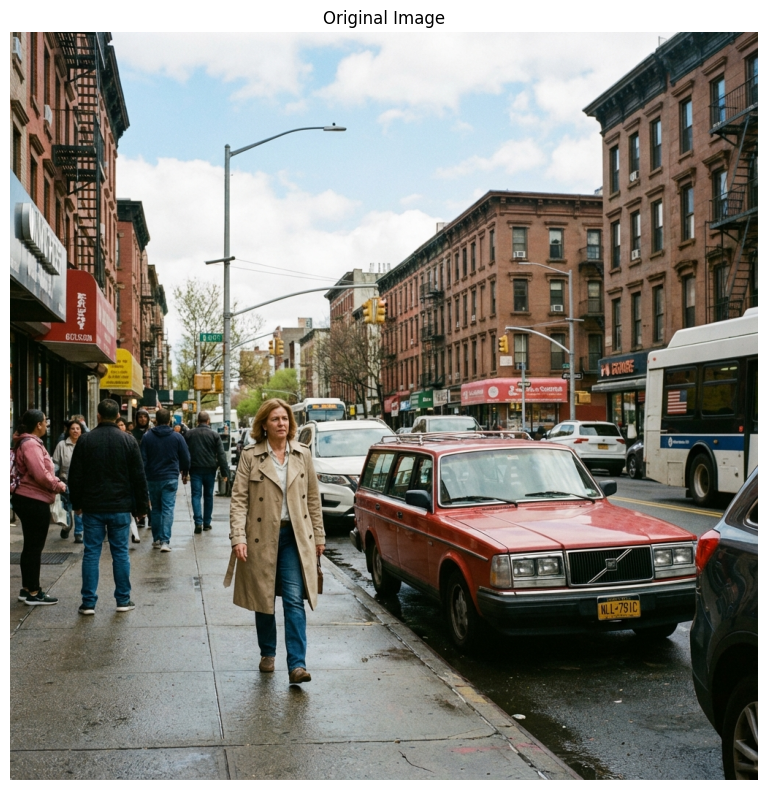

In [6]:
# Load test image
IMAGE_PATH = "test_images/street_scene.png"
CONF_THRESHOLD = 0.25
NMS_THRESHOLD = 0.45

print(f"Loading image: {IMAGE_PATH}")
img = cv2.imread(IMAGE_PATH)

if img is None:
    print(f"❌ Error: Could not read image '{IMAGE_PATH}'")
else:
    print(f"✅ Image loaded: {img.shape[1]}x{img.shape[0]} pixels")
    show_image(img, "Original Image")

In [7]:
# Preprocess image
original_img = img.copy()
img_tensor, ratio = preprocess(img, (INPUT_SIZE, INPUT_SIZE))
img_tensor = torch.from_numpy(img_tensor).unsqueeze(0).float().to(device)

print(f"Preprocessed tensor shape: {img_tensor.shape}")
print(f"Resize ratio: {ratio:.3f}")

Preprocessed tensor shape: torch.Size([1, 3, 640, 640])
Resize ratio: 0.625


In [11]:
# Run inference
print("Running inference...")
with torch.no_grad():
    outputs = model(img_tensor)
    outputs = postprocess(outputs, exp.num_classes, CONF_THRESHOLD, NMS_THRESHOLD)[0]

if outputs is None:
    print("❌ No detections found!")
else:
    print(f"✅ Inference complete!")
    print(f"   Raw detections: {len(outputs)}")

Running inference...
✅ Inference complete!
   Raw detections: 25



📊 Detected 25 objects:

   1. car             0.96 at [ 466,  552,  949,  849]
   2. person          0.94 at [ 295,  499,  434,  891]
   3. person          0.93 at [ 178,  516,  248,  710]
   4. person          0.92 at [  77,  506,  190,  799]
   5. person          0.91 at [   0,  514,   77,  786]
   6. bus             0.91 at [ 865,  379, 1022,  649]
   7. car             0.90 at [ 928,  587, 1023, 1006]
   8. person          0.89 at [ 237,  518,  295,  683]
   9. car             0.86 at [ 724,  531,  845,  609]
  10. car             0.81 at [ 392,  527,  533,  674]
  11. person          0.72 at [  55,  528,  102,  702]
  12. car             0.67 at [ 543,  523,  646,  553]
  13. person          0.60 at [ 163,  517,  195,  563]
  14. car             0.50 at [ 839,  555,  868,  610]
  15. traffic light   0.35 at [ 481,  365,  497,  399]
  16. truck           0.35 at [ 384,  500,  459,  548]
  17. car             0.34 at [ 639,  542,  717,  560]
  18. traffic light   0.32 at [ 489,  36

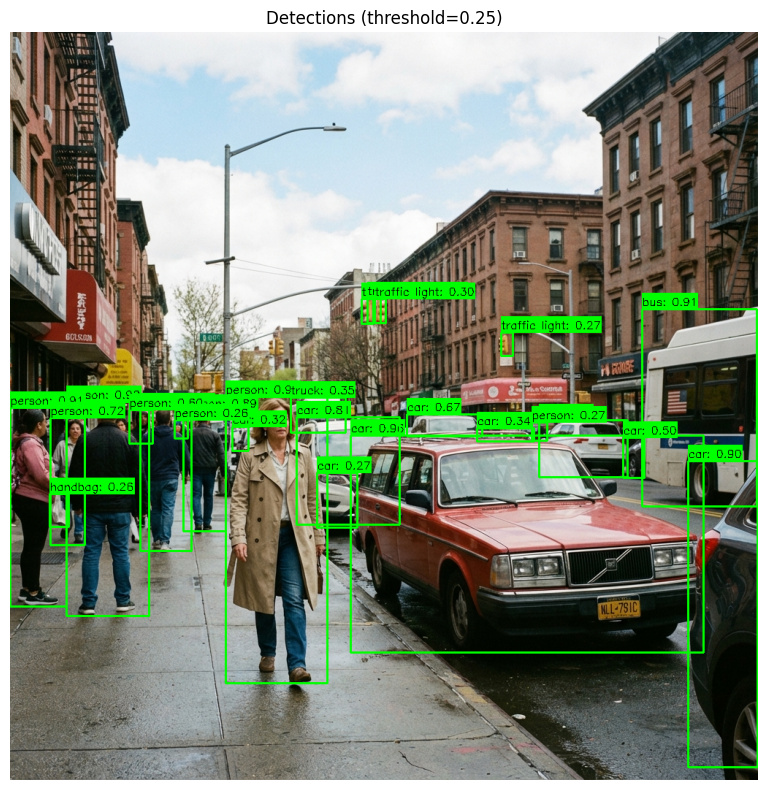


💾 Result saved to: notebook_output.jpg


In [12]:
# Process and display detections
if 'outputs' not in locals():
    print("❌ Error: 'outputs' is not defined. Please run the inference cell above first.")
else:
    if outputs is not None:
        outputs = outputs.cpu().numpy()
        bboxes = outputs[:, 0:4] / ratio
        cls = outputs[:, 6]
        scores = outputs[:, 4] * outputs[:, 5]
        
        # Print detection summary
        print(f"\n📊 Detected {len(bboxes)} objects:\n")
        
        detection_counts = {}
        for i, (bbox, score, cls_id) in enumerate(zip(bboxes, scores, cls)):
            x1, y1, x2, y2 = bbox.astype(int)
            class_name = COCO_CLASSES[int(cls_id)]
            detection_counts[class_name] = detection_counts.get(class_name, 0) + 1
            print(f"  {i+1:2d}. {class_name:15s} {score:.2f} at [{x1:4d}, {y1:4d}, {x2:4d}, {y2:4d}]")
        
        print(f"\n📈 Summary by class:")
        for class_name, count in sorted(detection_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"   {class_name}: {count}")
        
        # Draw detections
        result_img = draw_detections(original_img, bboxes, scores, cls, CONF_THRESHOLD)
        
        # Display result
        show_image(result_img, f"Detections (threshold={CONF_THRESHOLD})")
        
        # Save result
        output_path = "notebook_output.jpg"
        cv2.imwrite(output_path, result_img)
        print(f"\n💾 Result saved to: {output_path}")
    else:
        print("❌ No detections found!")

## 5. Experiment with Different Thresholds

Try adjusting the confidence threshold to see how it affects the detections.

In [14]:
# Compare different confidence thresholds
thresholds = [0.1, 0.3, 0.5, 0.7]

for threshold in thresholds:
    print(f"\n{'='*60}")
    print(f"Confidence threshold: {threshold}")
    print('='*60)
    # Preprocess image
    img_tensor, ratio = preprocess(img, (INPUT_SIZE, INPUT_SIZE))
    img_tensor = torch.from_numpy(img_tensor).unsqueeze(0).float().to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        outputs = postprocess(outputs, exp.num_classes, threshold, NMS_THRESHOLD)[0]
    if outputs is not None:
        outputs = outputs.cpu().numpy()
        num_detections = len(outputs)
    else:
        num_detections = 0
    print(f"Number of detections: {num_detections}")


Confidence threshold: 0.1
Number of detections: 41

Confidence threshold: 0.3
Number of detections: 19

Confidence threshold: 0.5
Number of detections: 14

Confidence threshold: 0.7
Number of detections: 11


## Summary

This notebook demonstrated:
- Loading and using the YOLOX object detection model
- Running inference on images
- Visualizing detection results
- Adjusting confidence thresholds

### Next Steps
- Try different YOLOX models (nano, tiny, medium, large, xlarge)
- Process video files using `process_video.py`
- Fine-tune the model on custom datasets
- Deploy the model for real-time applications